In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#Load MNIST dataset
train_dataset= torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transform)
test_dataset= torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size= 64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = 1000, shuffle = False)



In [5]:
# Define a simple feedforward neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lambda_ = np.random.beta(alpha, alpha)
    else:
        lambda_ = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lambda_ * x + (1 - lambda_) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lambda_


In [16]:
def cutmix_data(x, y, alpha=1.0):
    """Returns cutmix inputs and a cutmix label."""
    if alpha > 0:
        lambda_ = np.random.beta(alpha, alpha)
    else:
        lambda_ = 1

    batch_size, _, h, w = x.size()
    cut_rat = np.sqrt(1. - lambda_)
    cut_w = int(w * cut_rat)
    cut_h = int(h * cut_rat)

    cx = np.random.randint(w)
    cy = np.random.randint(h)

    bbx1 = np.clip(cx - cut_w // 2, 0, w)
    bby1 = np.clip(cy - cut_h // 2, 0, h)
    bbx2 = np.clip(cx + cut_w // 2, 0, w)
    bby2 = np.clip(cy + cut_h // 2, 0, h)

    index = torch.randperm(x.size(0)).to(x.device)

    x_copy = x.clone()
    x_copy[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]

    return x_copy, y, y[index], lambda_


In [17]:
def train(model, train_loader, criterion, optimizer, epochs, use_cutmix=False):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            # Move inputs and labels to the same device
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply Mixup or CutMix
            if use_cutmix:
                inputs, labels_a, labels_b, lambda_ = cutmix_data(inputs, labels)
            else:
                inputs, labels_a, labels_b, lambda_ = mixup_data(inputs, labels)

            optimizer.zero_grad()  # Zero out the gradients from the previous iteration
            outputs = model(inputs)  # Forward pass

            # Calculate the loss
            loss = lambda_ * criterion(outputs, labels_a) + (1 - lambda_) * criterion(outputs, labels_b)

            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Update the parameters

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize model, criterion, and optimizer
model = SimpleNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train with Mixup
print("Training with Mixup...")
train(model, train_loader, criterion, optimizer, epochs=5, use_cutmix=False)

# Train with CutMix
model = SimpleNet().to(device)  # Reinitialize the model for a fresh start
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Training with CutMix...")
train(model, train_loader, criterion, optimizer, epochs=5, use_cutmix=True)


Training with Mixup...
Epoch [1/5], Loss: 1.1369
Epoch [2/5], Loss: 0.7985
Epoch [3/5], Loss: 1.0641
Epoch [4/5], Loss: 1.0200
Epoch [5/5], Loss: 0.6073
Training with CutMix...
Epoch [1/5], Loss: 1.5532
Epoch [2/5], Loss: 1.1091
Epoch [3/5], Loss: 0.8232
Epoch [4/5], Loss: 1.7349
Epoch [5/5], Loss: 1.0499


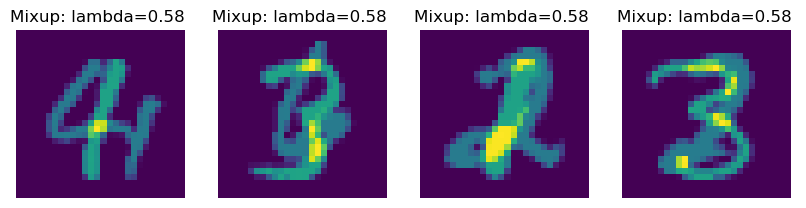

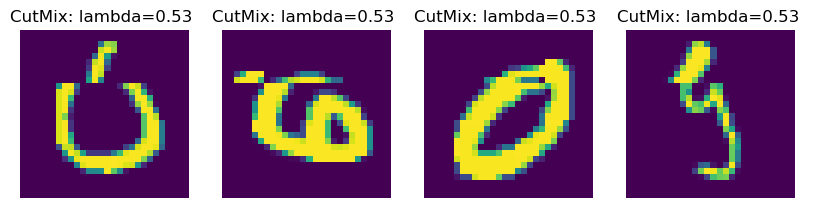

In [28]:
import matplotlib.pyplot as plt

def visualize_mixup_cutmix(inputs,lambda_, method="Mixup"):
    inputs = inputs.cpu().numpy()
    fig, axs = plt.subplots(1, 4, figsize=(10, 10))

    for i in range(4):
        axs[i].imshow(np.transpose(inputs[i], (1, 2, 0)))
        axs[i].set_title(f'{method}: lambda={lambda_:.2f} ')
        axs[i].axis('off')

    plt.show()

# After using Mixup or CutMix in training, you can visualize:
inputs, labels = next(iter(train_loader))
inputs, labels_a, labels_b, lambda_ = mixup_data(inputs, labels)
visualize_mixup_cutmix(inputs,  lambda_, method="Mixup")

# Generate CutMix visualization
inputs, labels = next(iter(train_loader))  # Fetch a batch from the data loader
inputs, labels_a, labels_b, lambda_ = cutmix_data(inputs, labels)  # Apply cutmix
visualize_mixup_cutmix(inputs, lambda_, method="CutMix") 
